In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/WELFake_Dataset.csv


In [2]:
import re 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.max_rows", None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
try:
    from xgboost import XGBClassifier
except:
    !pip install xgboost
    from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
try:
    from mlxtend.plotting import plot_confusion_matrix
except:
    !pip install mlxtend
    from mlxtend.plotting import plot_confusion_matrix
    
from IPython.display import Image
try:
    import stylecloud
except:
    !pip install stylecloud
    import stylecloud
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.4/161.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259510 sha256=946c3d30f3252fc6e3df82fd9ddb076c7f658a355b30c3ac942333e5e2c209a5
  Stored in directory: /root/.cache/pip/wheels/75/57/cf/e5f369b83198ecba2b12d5a564db116b4f07029d004d3e6c10
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=24c5b6d8285718a3082eed548fbefaaac0c7da960fe67ab729e06629dbe87e29
  Stored in directory: /root/.cache/pip/wheels/20/e8/7b/003fc14f02f262dd4614aec55e41147c8012e3dad98c936b76
  Created wheel for tinycss: fi

In [3]:
df=pd.read_csv("/kaggle/input/fake-news-classification/WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
df.shape

(72134, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [6]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
df.dropna(inplace=True)

In [8]:
df.duplicated().sum()

8416

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(63121, 3)

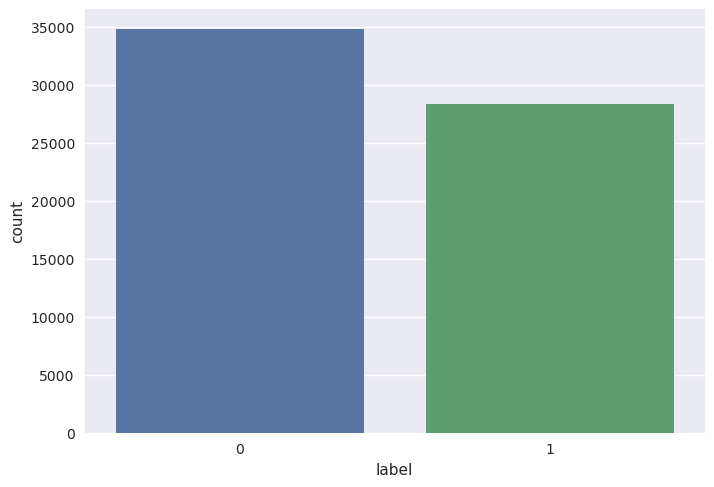

In [11]:
chart=sns.countplot(x='label',data=df)

In [12]:
df['txt']=df['title']+' '+df['text']
df.drop(columns=['title','text'],inplace=True)

In [13]:
df.head()

,label,txt
0,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,1,SATAN 2: Russia unvelis an image of its terrif...
5,1,About Time! Christian Group Sues Amazon and SP...


In [14]:
new_df=df.sample(20000).reset_index(drop='index')
new_df.head()

,label,txt
0,0,Breitbart News Daily: How Trump Won - Breitbar...
1,1,BRILLIANT! CNN ASKS BLACK TRUMP SUPPORTER The ...
2,0,India's muted response to Trump's Jerusalem mo...
3,0,U.S. agency to recommend scaling back some nat...
4,0,"Obama, ASEAN discuss South China Sea tensions,..."


In [15]:
new_df.shape

(20000, 2)

In [16]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [17]:
def process_text(text):
    # Remove punctuation
    text  = re.sub(r'[^a-zA-Z]',' ',text)
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # Remove stopwords
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    # Stemming words
    stemmed_words = [ps.stem(word) for word in clean_words]
    
    return " ".join(stemmed_words)

In [18]:
new_df['txt'] = new_df['txt'].apply(process_text)

In [19]:
new_df['txt'].head()

0    breitbart new daili trump breitbart tuesday ed...
1    brilliant cnn ask black trump support wrong qu...
2    india mute respons trump jerusalem move stoke ...
3    U agenc recommend scale back nation monument w...
4    obama asean discuss south china sea tension jo...
Name: txt, dtype: object

In [20]:
new_df.head()

,label,txt
0,0,breitbart new daili trump breitbart tuesday ed...
1,1,brilliant cnn ask black trump support wrong qu...
2,0,india mute respons trump jerusalem move stoke ...
3,0,U agenc recommend scale back nation monument w...
4,0,obama asean discuss south china sea tension jo...


In [21]:
x = new_df['txt']
y = new_df['label']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=24, shuffle =True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((10000,), (10000,), (10000,), (10000,))

In [23]:
my_tfidf = TfidfVectorizer()
x_train = my_tfidf.fit_transform(x_train).toarray()
x_test = my_tfidf.transform(x_test).toarray()

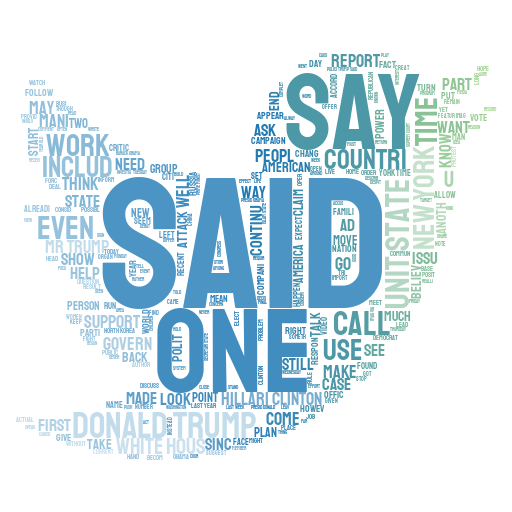

In [24]:
stylecloud.gen_stylecloud(text=" ".join(new_df['txt']), 
                          icon_name='fab fa-twitter',
                          palette='colorbrewer.qualitative.Paired_3', 
                          background_color='white',
                          gradient='horizontal')
Image('stylecloud.png')

In [25]:
train_scores = []
test_scores = []
CV=[]

def algorithm(model):
    # Training model
    model.fit(x_train,y_train)
            
    # score of train set
    train_model_score = model.score(x_train,y_train)
    train_scores.append(round(train_model_score,2))
    y_pred_train=model.predict(x_train)
    
    # score of test set
    test_model_score = model.score(x_test,y_test)
    test_scores.append(round(test_model_score,2))
    y_pred_test=model.predict(x_test)
    
    # train set using Cross validation
    cross_val = cross_val_score(model ,x_train ,y_train ,cv=10)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean,2))
    
    pickle.dump(model,open('model_' + str(model)[:-2] +'.pkl', 'wb'))
    
    print("Train score :",round(train_model_score,2))
    print("Test score :",round(test_model_score,2))
    print("Train CV mean :",round(cv_mean,2))
    
    df_model = pd.DataFrame(classification_report(y_pred_test,y_test, digits=2,output_dict=True)).T
    df_model['support'] = df_model.support.apply(int)
    df_model.style.background_gradient(cmap='viridis',subset=pd.IndexSlice['0':'9', :'f1-score'])
    display(df_model)
    
    print("\n----------------------Confusion Matrix---------------------- \n")
    conf_mat = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(conf_mat,
                      show_normed=True, colorbar=True,
                      class_names=['Fake', 'Real'])
    plt.show()

Train score : 0.96
Test score : 0.75
Train CV mean : 0.74


,precision,recall,f1-score,support
0,0.860536,0.739790,0.795608,6464
1,0.621427,0.780826,0.692067,3536
accuracy,0.754300,0.754300,0.754300,0
macro avg,0.740982,0.760308,0.743837,10000
weighted avg,0.775987,0.754300,0.758996,10000



----------------------Confusion Matrix---------------------- 



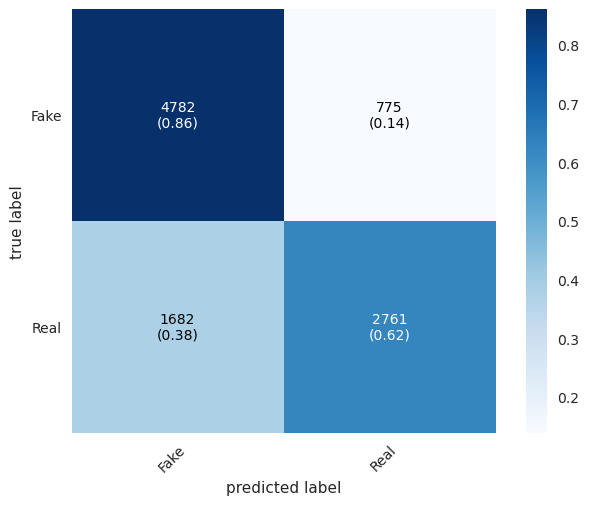

In [26]:
gnv=GaussianNB()
algorithm(gnv)

In [ ]:
mlp=MLPClassifier()
algorithm(mlp)

In [ ]:
rf=RandomForestClassifier()
algorithm(rf)

In [ ]:
bnv=BernoulliNB()
algorithm(bnv)

In [ ]:
xgb=XGBClassifier()
algorithm(xgb)